In [1]:
# packages

# JAX
import jax.numpy as jnp
from jax import grad, hessian, vmap
from jax.config import config; 
import jax.ops as jop
config.update("jax_enable_x64", True)

# numpy
import numpy as onp
from numpy import random 

# plot figures
import matplotlib.pyplot as plt

We solve the following Burgers equation 
\begin{equation*}
\begin{aligned}
& u_t+\alpha u u_x-\nu u_{xx}=0, x \in [-1,1], t \in [0,1]\\
& u(0,x)=-\sin(\pi x)\\
& u(t,-1)=u(t,1)=0
\end{aligned}
\end{equation*}
The parameter $\nu$ controls the shock.

In [2]:
# fix random seeds, for generating reference solution & sampled points
random.seed(20)

# we will use x=(x1,x2) as (t,x)

alpha = 1 # control the nonlinearity
nu = 0.02

# boundary condition
def u(x1, x2):
    return -jnp.sin(jnp.pi*x2)*(x1==0) + 0*(x2==0)

# right hand side
def f(x1, x2):
    return 0


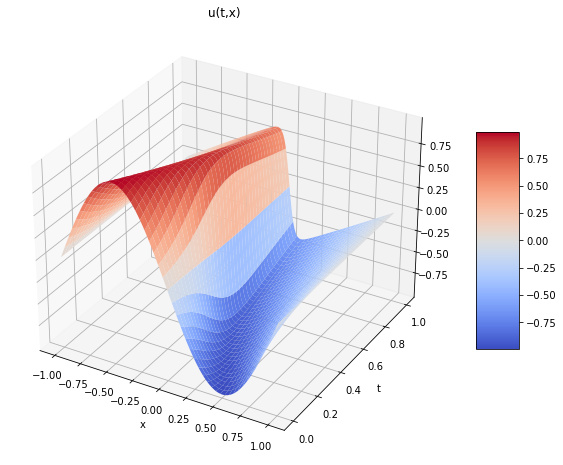

In [3]:
# obtain the ground truth solution via the Cole-Hopf transformation
# we use numerical integration to get the true solution

[Gauss_pts, weights] = onp.polynomial.hermite.hermgauss(80)

def u_true(x1, x2):
    temp = x2-jnp.sqrt(4*nu*x1)*Gauss_pts
    val1 = weights * jnp.sin(jnp.pi*temp) * jnp.exp(-jnp.cos(jnp.pi*temp)/(2*jnp.pi*nu))
    val2 = weights * jnp.exp(-jnp.cos(jnp.pi*temp)/(2*jnp.pi*nu))
    return -jnp.sum(val1)/jnp.sum(val2)

# plot the solution u(x,y), at the space-time domain or at a single time
    
def plot_u(num_pts1, num_pts2):
    xx = onp.linspace(0, 1, num_pts1)
    yy = onp.linspace(-1, 1, num_pts2)
    XX, YY = onp.meshgrid(xx, yy)

    # vectorized (x,y) coordinates
    XXv = onp.array(XX.flatten())
    YYv = onp.array(YY.flatten())

    ZZ_u = vmap(u_true)(XXv, YYv)
    ZZ_u = ZZ_u.reshape(num_pts2,num_pts1)
    
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(111, projection='3d')
    u_surf=ax.plot_surface(YY, XX, ZZ_u, cmap=plt.cm.coolwarm)
    plt.xlabel('x')
    plt.ylabel('t')
    plt.title('u(t,x)')
    
    fig.colorbar(u_surf, shrink= 0.5, aspect = 5)
    plt.show()
    
def plot_u_time_t(t, num_pts):
    xx = t
    yy = onp.linspace(-1, 1, num_pts)
    XX, YY = onp.meshgrid(xx, yy)

    # vectorized (x,y) coordinates
    XXv = onp.array(XX.flatten())
    YYv = onp.array(YY.flatten())

    ZZ_u = vmap(u_true)(XXv, YYv)
    
    fig = plt.figure(figsize=(12,8))
    plt.plot(yy, ZZ_u)
    plt.xlabel('x')
    plt.title('u(t,x) at time %f' %t)
    plt.show()
    
# test
# plot the figure
plot_u(40,400)

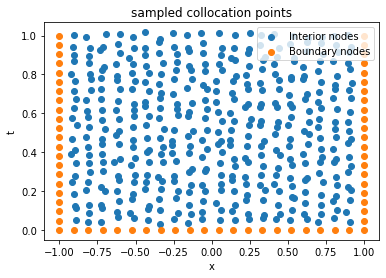

In [4]:
# sampled collocation points

def sample_points_grid(N_pts, int_perturb = 0.4, bd_rdm = False):
    xx= onp.linspace(0, 1, N_pts+2)
    yy = onp.linspace(-1, 1, N_pts+2)
    XX, YY = onp.meshgrid(xx, yy)

    XX_int = XX[1:N_pts+1, 1:N_pts+2]
    YY_int = YY[1:N_pts+1, 1:N_pts+2]

    # vectorized (x,y) coordinates
    XXv_int = onp.array(XX_int.flatten())
    YYv_int = onp.array(YY_int.flatten())

    XXv_int = onp.expand_dims(XXv_int, axis=1) 
    YYv_int = onp.expand_dims(YYv_int, axis=1) 
    
    XXv_bd = onp.concatenate((XX[0,1:N_pts+2], XX[N_pts+1,1:N_pts+2], XX[0:N_pts+2,0]), axis = 0)
    YYv_bd = onp.concatenate((YY[0,1:N_pts+2], YY[N_pts+1,1:N_pts+2], YY[0:N_pts+2,0]), axis = 0)

    XXv_bd = onp.expand_dims(XXv_bd, axis=1) 
    YYv_bd = onp.expand_dims(YYv_bd, axis=1) 
    X_domain = onp.concatenate((XXv_int, YYv_int), axis=1)+int_perturb*random.uniform(-1/N_pts, 1/N_pts, (XXv_int.shape[0],2))
    X_boundary = onp.concatenate((XXv_bd, YYv_bd), axis=1)
    
    if bd_rdm:
        N_boundary = 3*(N_pts+1)
        X_boundary = onp.zeros((N_boundary, 2))

        # generate random boundary points on the faces of the domain 

        # bottom face
        X_boundary[:int(N_boundary/3), 1] = random.uniform(-1.0, 1.0, int(N_boundary/3))
        # right face
        X_boundary[int(N_boundary/3):2*int(N_boundary/3), 0] = random.uniform(0.0, 1.0, int(N_boundary/3))
        X_boundary[int(N_boundary/3):2*int(N_boundary/3), 1] = 1
        # left face
        X_boundary[2*int(N_boundary/3):, 0] = random.uniform(0.0, 1.0, int(N_boundary/3))
        X_boundary[2*int(N_boundary/3):, 1] = -1
    
    return X_domain, X_boundary


N_pts = 20
N_domain_tot = N_pts**2+N_pts
N_boundary_tot = 3*(N_pts+1)+1
X_domain_tot, X_boundary_tot = sample_points_grid(N_pts, bd_rdm = False)

fig, ax = plt.subplots()
ax.scatter(X_domain_tot[range(N_domain_tot), 1], X_domain_tot[range(N_domain_tot), 0], label='Interior nodes')
ax.scatter(X_boundary_tot[range(N_boundary_tot), 1], X_boundary_tot[range(N_boundary_tot), 0], label='Boundary nodes')
ax.legend(loc="upper right")
ax.set_xlabel('x')
ax.set_ylabel('t')
plt.title('sampled collocation points')
plt.show()

In [5]:
# kernels and derivatives

def kappa(x1, x2, y1, y2, sigma):
    # x,y are 2D input row vectors
    
    scale_t = sigma[0]
    scale_x = sigma[1]
    
    r = (scale_t*(x1-y1))**2+(scale_x*(x2-y2))**2

    return jnp.exp(-r)


def D_x1_kappa(x1, x2, y1, y2, sigma):
    val = grad(kappa,0)(x1, x2, y1, y2, sigma)
    return val

def D_x2_kappa(x1, x2, y1, y2, sigma):
    val = grad(kappa,1)(x1, x2, y1, y2, sigma)
    return val

def DD_x2_kappa(x1, x2, y1, y2, sigma):
    val = grad(grad(kappa,1),1)(x1, x2, y1, y2, sigma)
    return val

def D_y1_kappa(x1, x2, y1, y2, sigma):
    val = grad(kappa,2)(x1, x2, y1, y2, sigma)
    return val

def D_y2_kappa(x1, x2, y1, y2, sigma):
    val = grad(kappa,3)(x1, x2, y1, y2, sigma)
    return val

def DD_y2_kappa(x1, x2, y1, y2, sigma):
    val = grad(grad(kappa,3),3)(x1, x2, y1, y2, sigma)
    return val

def D_x1_D_y1_kappa(x1, x2, y1, y2, sigma):
    val = grad(grad(kappa,0),2)(x1, x2, y1, y2, sigma)
    return val

def D_x1_D_y2_kappa(x1, x2, y1, y2, sigma):
    val = grad(grad(kappa,0),3)(x1, x2, y1, y2, sigma)
    return val

def D_x1_DD_y2_kappa(x1, x2, y1, y2, sigma):
    val = grad(grad(grad(kappa,0),3),3)(x1, x2, y1, y2, sigma)
    return val

def D_x2_D_y2_kappa(x1, x2, y1, y2, sigma):
    val = grad(grad(kappa,1),3)(x1, x2, y1, y2, sigma)
    return val

def D_x2_DD_y2_kappa(x1, x2, y1, y2, sigma):
    val = grad(grad(grad(kappa,1),3),3)(x1, x2, y1, y2, sigma)
    return val

def DD_x2_DD_y2_kappa(x1, x2, y1, y2, sigma):
    val = grad(grad(grad(grad(kappa,1),1),3),3)(x1, x2, y1, y2, sigma)
    return val


Now, we will construct the Gram matrix, based on the observation $u(x_i), u_t(x_i), u_x(x_i), u_{xx}(x_i)$

We organize all the variables in the way: $[v_1,v_2,v_3,v_0,v_b]$, where $v_0, v_1, v_2, v_3$ represent the interior nodal values of $u(x_i), u_t(x_i), u_x(x_i), u_{xx}(x_i)$, respectively; and $v_b$ is the boundary value. 

The Gram matrix $\Theta$ is then determined by this organization. Next code block is to construct this matrix.


In [6]:
# vectorized construction of the Gram matrix Theta
def assembly_Theta(X_domain, X_boundary, nugget, set_sigma):
    
    N_domain = X_domain.shape[0]
    N_boundary = X_boundary.shape[0]
    Theta = jnp.zeros((4*N_domain + N_boundary, 4*N_domain + N_boundary))

    # auxiliary variables to make things readable
    # interior points coordinates
    Xd0=X_domain[:N_domain, 0]
    Xd1=X_domain[:N_domain, 1]
    
    # interior + boundary points coordinates
    Xdb0=jnp.concatenate([Xd0, X_boundary[:N_boundary, 0]])
    Xdb1=jnp.concatenate([Xd1, X_boundary[:N_boundary, 1]])

    # interior v.s. interior interaction (used for construct kernel matrix)
    XXdd0=jnp.transpose(jnp.tile(Xd0,(N_domain,1)))
    XXdd1=jnp.transpose(jnp.tile(Xd1,(N_domain,1)))

    # interior+boudary v.s. interior+bpundary interaction
    XXdbdb0=jnp.transpose(jnp.tile(Xdb0,(N_domain+N_boundary,1)))
    XXdbdb1=jnp.transpose(jnp.tile(Xdb1,(N_domain+N_boundary,1)))

    # interior v.s. interior+boundary interaction
    XXddb0=jnp.transpose(jnp.tile(Xd0,(N_domain+N_boundary,1)))
    XXddb1=jnp.transpose(jnp.tile(Xd1,(N_domain+N_boundary,1)))
    XXddb0_2=jnp.tile(Xdb0,(N_domain,1))
    XXddb1_2=jnp.tile(Xdb1,(N_domain,1))

    # Construct kernel matrix
    # interior v.s. interior 
    val = vmap(lambda x1, x2, y1, y2: D_x1_D_y1_kappa(x1, x2, y1, y2, set_sigma))(XXdd0.flatten(),XXdd1.flatten(),jnp.transpose(XXdd0).flatten(),jnp.transpose(XXdd1).flatten())
    Theta = jop.index_update(Theta, jop.index[0:N_domain, 0:N_domain], jnp.reshape(val, (N_domain, N_domain)))
    
    val = vmap(lambda x1, x2, y1, y2: D_x1_D_y2_kappa(x1, x2, y1, y2, set_sigma))(XXdd0.flatten(),XXdd1.flatten(),jnp.transpose(XXdd0).flatten(),jnp.transpose(XXdd1).flatten())
    Theta = jop.index_update(Theta, jop.index[0:N_domain, N_domain:2*N_domain], jnp.reshape(val, (N_domain, N_domain)))
    Theta = jop.index_update(Theta, jop.index[N_domain:2*N_domain, 0:N_domain], jnp.transpose(jnp.reshape(val, (N_domain, N_domain))))
    
    val = vmap(lambda x1, x2, y1, y2: D_x1_DD_y2_kappa(x1, x2, y1, y2, set_sigma))(XXdd0.flatten(),XXdd1.flatten(),jnp.transpose(XXdd0).flatten(),jnp.transpose(XXdd1).flatten())
    Theta = jop.index_update(Theta, jop.index[0:N_domain, 2*N_domain:3*N_domain], jnp.reshape(val, (N_domain, N_domain)))
    Theta = jop.index_update(Theta, jop.index[2*N_domain:3*N_domain, 0:N_domain], jnp.transpose(jnp.reshape(val, (N_domain, N_domain))))
    
    val = vmap(lambda x1, x2, y1, y2: D_x2_D_y2_kappa(x1, x2, y1, y2, set_sigma))(XXdd0.flatten(),XXdd1.flatten(),jnp.transpose(XXdd0).flatten(),jnp.transpose(XXdd1).flatten())
    Theta = jop.index_update(Theta, jop.index[N_domain:2*N_domain, N_domain:2*N_domain], jnp.reshape(val, (N_domain, N_domain)))
    
    val = vmap(lambda x1, x2, y1, y2: D_x2_DD_y2_kappa(x1, x2, y1, y2, set_sigma))(XXdd0.flatten(),XXdd1.flatten(),jnp.transpose(XXdd0).flatten(),jnp.transpose(XXdd1).flatten())
    Theta = jop.index_update(Theta, jop.index[N_domain:2*N_domain, 2*N_domain:3*N_domain], jnp.reshape(val, (N_domain, N_domain)))
    Theta = jop.index_update(Theta, jop.index[2*N_domain:3*N_domain, N_domain:2*N_domain], jnp.transpose(jnp.reshape(val, (N_domain, N_domain))))
    
    val = vmap(lambda x1, x2, y1, y2: DD_x2_DD_y2_kappa(x1, x2, y1, y2, set_sigma))(XXdd0.flatten(),XXdd1.flatten(),jnp.transpose(XXdd0).flatten(),jnp.transpose(XXdd1).flatten())
    Theta = jop.index_update(Theta, jop.index[2*N_domain:3*N_domain, 2*N_domain:3*N_domain], jnp.reshape(val, (N_domain, N_domain)))
    
    # interior+boundary v.s. interior+boundary
    val = vmap(lambda x1, x2, y1, y2: kappa(x1, x2, y1, y2, set_sigma))(XXdbdb0.flatten(),XXdbdb1.flatten(),jnp.transpose(XXdbdb0).flatten(),jnp.transpose(XXdbdb1).flatten())
    Theta = jop.index_update(Theta, jop.index[3*N_domain:, 3*N_domain:], jnp.reshape(val, (N_domain+N_boundary, N_domain+N_boundary)))
    
    # interior v.s. interior+boundary
    val = vmap(lambda x1, x2, y1, y2: D_x1_kappa(x1, x2, y1, y2, set_sigma))(XXddb0.flatten(),XXddb1.flatten(),XXddb0_2.flatten(),XXddb1_2.flatten())
    Theta = jop.index_update(Theta, jop.index[0:N_domain, 3*N_domain:], jnp.reshape(val, (N_domain, N_domain+N_boundary)))
    Theta = jop.index_update(Theta, jop.index[3*N_domain:, 0:N_domain], jnp.transpose(jnp.reshape(val, (N_domain, N_domain+N_boundary))))
    
    val = vmap(lambda x1, x2, y1, y2: D_x2_kappa(x1, x2, y1, y2, set_sigma))(XXddb0.flatten(),XXddb1.flatten(),XXddb0_2.flatten(),XXddb1_2.flatten())
    Theta = jop.index_update(Theta, jop.index[N_domain:2*N_domain, 3*N_domain:], jnp.reshape(val, (N_domain, N_domain+N_boundary)))
    Theta = jop.index_update(Theta, jop.index[3*N_domain:, N_domain:2*N_domain], jnp.transpose(onp.reshape(val, (N_domain, N_domain+N_boundary))))
    
    val = vmap(lambda x1, x2, y1, y2: DD_x2_kappa(x1, x2, y1, y2, set_sigma))(XXddb0.flatten(),XXddb1.flatten(),XXddb0_2.flatten(),XXddb1_2.flatten())
    Theta = jop.index_update(Theta, jop.index[2*N_domain:3*N_domain, 3*N_domain:], jnp.reshape(val, (N_domain, N_domain+N_boundary)))
    Theta = jop.index_update(Theta, jop.index[3*N_domain:, 2*N_domain:3*N_domain], jnp.transpose(jnp.reshape(val, (N_domain, N_domain+N_boundary))))
    
    # calculate trace
    trace1 = jnp.trace(Theta[:N_domain, :N_domain])
    trace2 = jnp.trace(Theta[N_domain:2*N_domain, N_domain:2*N_domain])
    trace3 = jnp.trace(Theta[2*N_domain:3*N_domain, 2*N_domain:3*N_domain])
    trace4 = jnp.trace(Theta[3*N_domain:, 3*N_domain:])
    ratio = [trace1/trace4, trace2/trace4, trace3/trace4]
    
    temp=jnp.concatenate((ratio[0]*jnp.ones((1,N_domain)), ratio[1]*jnp.ones((1,N_domain)), ratio[2]*jnp.ones((1,N_domain)), jnp.ones((1,N_domain+N_boundary))), axis=1)
    Theta = Theta + nugget*jnp.diag(temp[0]) 
    L = jnp.linalg.cholesky(Theta)
    
    return L


In the above, we added trace-adaptive nugget terms to regularize the Gram matrix
\begin{equation*}
\Theta_{\lambda} = \Theta +
\text{nugget}\times\begin{bmatrix}
\lambda_1 I & 0 & 0 & 0\\
0 & \lambda_2 I & 0 & 0\\
0 & 0 & \lambda_3I & 0 \\
0 & 0 & 0 & I
\end{bmatrix}
\end{equation*}
where $\lambda_1, \lambda_2, \lambda_3$ are selected to be the trace ratios of the orginal Gram matrix

Then, we solve the following optimization problem:
\begin{equation*}
\begin{aligned}
\min&\quad   [v_1,v_2,v_3,v_0,v_b]\Theta_{\lambda}^{-1} [v_1,v_2,v_3,v_0,v_b]^T\\
  \text{s.t.}&\quad v_1+\alpha v_0v_2-\nu v_3=f, \text{ and } v_b = \text{boundary data}
\end{aligned}
\end{equation*}

Here, $v_0, v_1, v_2, v_3$ represent the interior nodal values of $u(x_i), u_t(x_i), u_x(x_i), u_{xx}(x_i)$, respectively.

In [7]:
# loss functions
def J(v,rhs_f,bdy_g,L):
    N_domain = rhs_f.shape[0]
    v0 = v[:N_domain]
    v2 = v[N_domain:2*N_domain]
    v3 = v[2*N_domain:]
    
    vv = jnp.append(nu*v3+rhs_f-alpha*v0*v2, v2)
    vv = jnp.append(vv, v3)
    vv = jnp.append(vv, v0)
    vv = jnp.append(vv, bdy_g)
    temp = jnp.linalg.solve(L,vv)
    return jnp.dot(temp, temp)

# gradient of loss functions
grad_J = grad(J)

# Hessian in the Gaussian Newton method
def Hessian_GN(v,rhs_f,bdy_g,L):
    N_domain = rhs_f.shape[0]
    N_boundary = bdy_g.shape[0]
    v0 = v[:N_domain]
    v2 = v[N_domain:2*N_domain]
    v3 = v[2*N_domain:]

    mtx = jnp.zeros((4*N_domain+N_boundary, 3*N_domain))
    mtx1 = jnp.concatenate((-alpha*jnp.diag(v2), -alpha*jnp.diag(v0), nu*jnp.eye(N_domain)), axis=1)
    mtx = jop.index_update(mtx, jop.index[0:N_domain, :], mtx1)
    mtx = jop.index_update(mtx, jop.index[N_domain:2*N_domain, N_domain:2*N_domain], jnp.eye(N_domain))
    mtx = jop.index_update(mtx, jop.index[2*N_domain:3*N_domain, 2*N_domain:3*N_domain], jnp.eye(N_domain))
    mtx = jop.index_update(mtx, jop.index[3*N_domain:4*N_domain, :N_domain], jnp.eye(N_domain))
    ss = jnp.linalg.solve(L, mtx)
    return 2*jnp.matmul(jnp.transpose(ss),ss)

Hessian_J = hessian(J)

# solve PDEs
def pde_solver(X_domain, X_boundary, nugget, max_iter, initial_sol, set_sigma, output_history = 0):
    N_domain = X_domain.shape[0]
    
    rhs_f = vmap(f)(X_domain[:,0], X_domain[:,1])  # rhs data
    bdy_g = vmap(u)(X_boundary[:,0], X_boundary[:,1]) # boundary data

    # define cost function
    L = assembly_Theta(X_domain, X_boundary, nugget, set_sigma)
    sol = initial_sol
    step_size = 0.5
    
    for iter_step in range(max_iter):
        temp = jnp.linalg.solve(Hessian_GN(sol,rhs_f,bdy_g,L), grad_J(sol,rhs_f,bdy_g,L))
        if iter_step > 10:
            step_size = 1
        sol = sol - step_size*temp
        
        # iteration history
        if output_history == 1:
            J_now = J(sol,rhs_f,bdy_g,L)
            print('iter = ', iter_step, 'Gauss-Newton step size =', step_size, ' J = ', J_now)
    J_now = J(sol,rhs_f,bdy_g,L)
    return sol, J_now, rhs_f, bdy_g, L




In [8]:
# ----- test pde solution
nugget=1e-5
max_iter=15
initial_sol=random.normal(0, 1.0, (3*N_domain_tot))
set_sigma=jnp.array([3,20])
print('parameter sigma is set to be ', set_sigma)
sol, J_final, rhs_f, bdy_g, L = pde_solver(X_domain_tot, X_boundary_tot, nugget, max_iter, initial_sol, set_sigma, 1)


parameter sigma is set to be  [ 3 20]
iter =  0 Gauss-Newton step size = 0.5  J =  9329193.899339551
iter =  1 Gauss-Newton step size = 0.5  J =  2391205.3566080667
iter =  2 Gauss-Newton step size = 0.5  J =  607549.9222756745
iter =  3 Gauss-Newton step size = 0.5  J =  154424.63903683715
iter =  4 Gauss-Newton step size = 0.5  J =  40186.235135831936
iter =  5 Gauss-Newton step size = 0.5  J =  10593.670809293424
iter =  6 Gauss-Newton step size = 0.5  J =  2888.029572489758
iter =  7 Gauss-Newton step size = 0.5  J =  839.0324467066056
iter =  8 Gauss-Newton step size = 0.5  J =  251.29817337985264
iter =  9 Gauss-Newton step size = 0.5  J =  78.3830584925146
iter =  10 Gauss-Newton step size = 0.5  J =  30.46284675495492
iter =  11 Gauss-Newton step size = 1  J =  13.486331355425705
iter =  12 Gauss-Newton step size = 1  J =  13.31782351037131
iter =  13 Gauss-Newton step size = 1  J =  13.317426621003673
iter =  14 Gauss-Newton step size = 1  J =  13.31742660108911


In [9]:
X_domain_tot

array([[ 0.05114428, -0.88885336],
       [ 0.11089932, -0.89212841],
       [ 0.12429273, -0.8970916 ],
       [ 0.18562343, -0.90402147],
       [ 0.2444133 , -0.9170079 ],
       [ 0.27660694, -0.89601767],
       [ 0.34465348, -0.8907488 ],
       [ 0.39196218, -0.92329533],
       [ 0.41323918, -0.89471068],
       [ 0.4657592 , -0.91456966],
       [ 0.53811455, -0.88677074],
       [ 0.57389605, -0.91761068],
       [ 0.6298577 , -0.90506666],
       [ 0.67191679, -0.89118199],
       [ 0.71272729, -0.9048443 ],
       [ 0.76908121, -0.89873047],
       [ 0.80027562, -0.92206892],
       [ 0.86800066, -0.90552254],
       [ 0.89793016, -0.90433626],
       [ 0.94292611, -0.91234144],
       [ 1.00507414, -0.90246391],
       [ 0.04036223, -0.81373008],
       [ 0.08555708, -0.80623416],
       [ 0.12932229, -0.80559846],
       [ 0.20350913, -0.82326814],
       [ 0.24746726, -0.81317807],
       [ 0.2968618 , -0.79736499],
       [ 0.34477619, -0.80583233],
       [ 0.38753195,

In [10]:
# Laplace approximation
mean_Laplace = sol
cov_Laplace = jnp.linalg.inv(Hessian_J(sol,rhs_f, bdy_g, L))
cov_Kalman = jnp.linalg.inv(Hessian_GN(sol,rhs_f, bdy_g, L))

In [11]:
XX = jnp.reshape(X_domain_tot[:,1], (N_pts, N_pts+1))
YY = jnp.reshape(X_domain_tot[:,0], (N_pts, N_pts+1))
grid_sol = jnp.reshape(sol[:N_domain_tot], (N_pts, N_pts+1))
grid_cov_Laplace = jnp.reshape(jnp.diag(cov_Laplace)[:N_domain_tot],(N_pts, N_pts+1))
grid_cov_Kalman = jnp.reshape(jnp.diag(cov_Kalman)[:N_domain_tot],(N_pts, N_pts+1))

Text(0.5, 1.0, 'Laplace_std')

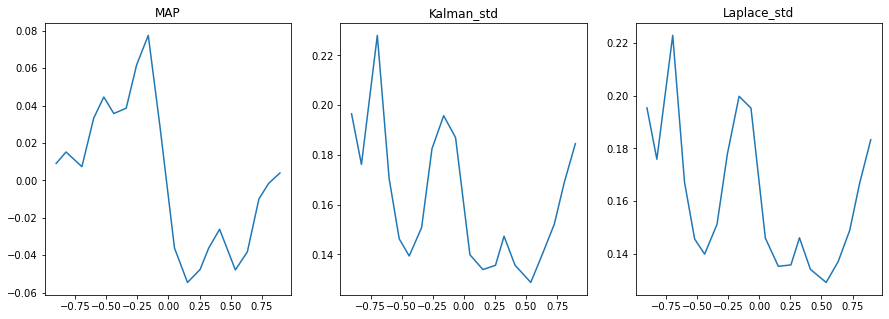

In [12]:
fig = plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.plot(XX[:,-1], grid_sol[:,-1], label = "MAP")
plt.title("MAP")
# plt.colorbar()

plt.subplot(132)
plt.plot(XX[:,-1], grid_cov_Kalman[:,-1], label = "Kalman_std")
plt.title("Kalman_std")
# plt.colorbar()

plt.subplot(133)
plt.plot(XX[:,-1], grid_cov_Laplace[:,-1], label = "Laplace_std")
plt.title("Laplace_std")
# plt.colorbar()
# legend()

In [ ]:
np.abs(grid_cov_Laplace - grid_cov_Kalman).mean()/np.abs(grid_cov_Kalman).mean()

In [ ]:
XX[:,-1]